In this notebook we investigate why the slope of phase boundary look like that

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import autograd
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
from diffthermo.utils import _convert_JMCA_Tdsdx_data_to_dsdx
from diffthermo.utils_PDOS import read_OCV_data, _get_phase_boundaries
from diffthermo.energy import _H_vib_PDOS_quaderature_model, _S_vib_PDOS_quaderature_model, _PDOS_evaluator, calculate_S_config_total, calculate_S_vib_total_PDOS, solve_Theta_max
from diffthermo.energy import GibbsFE_PDOS as GibbsFE

Import data and parameter settings

In [2]:
# read-in Cp data
# read cp experimental data of LiC6
df = pd.read_csv("cp_LiC6.csv",header=None) # deleted those datapoints within miscibility gaps
data = df.to_numpy()
T_measured_LiC6 = data[:,0] 
Cp_measured_LiC6 = data[:,1]/7
# read cp experimental data of C6
df = pd.read_csv("Cp_C6.csv",header=None) # deleted those datapoints within miscibility gaps
data = df.to_numpy()
T_measured_C6 = data[:,0] 
Cp_measured_C6 = data[:,1] * 4.184/(1/(12*6))/6   # convert cal/(g.K) to J/(mol.K)

# convert data
Ts_measured_C6 = torch.from_numpy(T_measured_C6)
Cps_measured_C6 = torch.from_numpy(Cp_measured_C6)
Ts_measured_LiC6 = torch.from_numpy(T_measured_LiC6)
Cps_measured_LiC6 = torch.from_numpy(Cp_measured_LiC6)

# global settings
quaderature_points = 20
style = "Legendre"


Import experimental measured PDOS of C6

In [3]:
# read PDOS experimental data of C6
df = pd.read_csv("PDOS_C6.csv",header=None) 
data = df.to_numpy()
Theta_experiment = data[:,0]/0.0257*300
PDOS_density = data[:,1]


Import experimental measured dsdx data of LixC6 vs x

In [4]:
x_measured_dsdx, dsdx_measured = _convert_JMCA_Tdsdx_data_to_dsdx(datafile_name="TdS_dx_lithiation_320K.csv", T=320)

Import experimental measured OCV data of LixC6 vs x

In [5]:
x1, mu1 = read_OCV_data('47C_lithiation.csv')
T1 = 320
x2, mu2 = read_OCV_data('25C_lithiation.csv')
T2 = 273+25
x3, mu3 = read_OCV_data('57C_lithiation.csv')
T3 = 273+57
x4, mu4 = read_OCV_data('10C_lithiation.csv')
T4 = 273+10

Import fitted PDOS params of fitted LixHM

In [6]:
# Epoch 2884  Loss 0.2231  OCV1 0.0223  OCV2 0.0184  OCV3 0.0330  loss_entropy 125.6291 (dSdx_col 120.1054) Cp_HM 12.1219 Cp_LiHM 11.6010 PD 0.0000    
# Omega0 -3466.6855 Omega1 7414.4780 Omega2 4328.5479 Omega3 -4680.6987 Omega4 -6743.4790 Omega5 -3946.8042 G0 1663.8445 
# omega0 -0.56373113 omega1 0.19531932 omega2 0.40005654 omega3 -0.12321223 omega4 -0.55982774 omega5 0.00079821 omega6 -0.13891523 omega7 -0.18185402 omega8 -0.16848527 omega9 -0.04778971 omega10 -0.09443944 
# g00 1.05817294 g01 0.35428974 
# g10 -0.97393298 g11 -0.69093841
# g20 0.07089702 g21 0.06956254 
# g30 1.01894021 g31 0.11906901        

# initialize g_i_list 
g_ij_list_LixHM = [[ 1.05817294 , 0.35428974 ],
                   [ -0.97393298 , -0.69093841],
                   [ 0.07089702 , 0.06956254 ],
                   [ 1.01894021 , 0.11906901  ]]


Import Hmix parameters (Omegas and G0)

In [7]:
Omega_G0_list = [-3466.6855 , 7414.4780 , 4328.5479 , -4680.6987 , -6743.4790 , -3946.8042 ,    0.0] # G0=1663.8445

Import Smix parameters (omegas)

In [8]:
S_config_params_list  = [-0.56373113 , 0.19531932 , 0.40005654 , -0.12321223 , -0.55982774 , 0.00079821 , -0.13891523 , -0.18185402 , -0.16848527 , -0.04778971 , -0.09443944  ]

Import fitted PDOS params for Li, HM and LiHM

In [9]:
n_list = [9999.9, 6.0, 1.0]
g_i_list_Li = [2.20836568 , 0.58406430 , 1.28776312 , -0.53589582 ] # pretrained via fit_pure_substance_Cp
g_i_list_HM = [ 0.91502953 , -0.89132202 , 0.06308235 , 0.92034441 ] # pretrained via fit_pure_substance_Cp
g_i_list_LiHM = [ 1.03142691 , -0.54386890 , 0.02469020 , 1.19035435] # pretrained via fit_pure_substance_Cp

# convert pretrained value into torch.tensor
g_i_list_Li = torch.tensor(g_i_list_Li) 
g_i_list_HM = torch.tensor(g_i_list_HM)
g_i_list_LiHM = torch.tensor(g_i_list_LiHM) 
Theta_max_Li = solve_Theta_max(g_i_list = g_i_list_Li, is_x_dependent = False, style = style)
Theta_max_Li = Theta_max_Li.detach()
Theta_max_HM = solve_Theta_max(g_i_list = g_i_list_HM, is_x_dependent = False, style = style)
Theta_max_HM = Theta_max_HM.detach()
Theta_max_LiHM = solve_Theta_max(g_i_list = g_i_list_LiHM, is_x_dependent = False, style = style)
Theta_max_LiHM = Theta_max_LiHM.detach()

In [10]:
## define a total params list for GibbsFE function as input
total_params_list = [Omega_G0_list, S_config_params_list, n_list, g_ij_list_LixHM, g_i_list_HM, g_i_list_Li, Theta_max_HM, Theta_max_Li]

Test G, H, S, H_vib, H_mix, S_mix, S_vib of graphite at 2 different temp

In [11]:
_xs = np.linspace(0.01,0.99, 99).astype("float32")

xs = []
for i in range(0, len(_xs)):
    xs.append(torch.tensor(_xs[i]).requires_grad_())

T1 = 300
T2 = 330

In [12]:
from diffthermo.energy import legendre_poly_recurrence
def Hmix_calc(x, enthalpy_mixing_params_list):
    # H_mix
    G0 = enthalpy_mixing_params_list[-1]
    G = x*G0 + (1-x)*0.0 
    t = 2 * x -1 # Transform x to (2x-1) for legendre expansion
    Pn_values = legendre_poly_recurrence(t, len(enthalpy_mixing_params_list)-2)  # Compute Legendre polynomials up to degree len(coeffs) - 1 # don't need to get Pn(G0)
    for i in range(0, len(enthalpy_mixing_params_list)-1):
        G = G + x*(1-x)*(enthalpy_mixing_params_list[i]*Pn_values[i])
    return G

def _calculate_S_config_total(x, S_config_params_list):
    S_ideal = -8.314*(x*torch.log(x) + (1-x)*torch.log(1-x) )
    S_expand = 1.0
    t = 2 * x -1 # Transform x to (2x-1) for legendre expansion
    Pn_values = legendre_poly_recurrence(t, len(S_config_params_list)-1) 
    for i in range(0, len(S_config_params_list)):
        S_expand = S_expand + S_config_params_list[i] * Pn_values[i]
    S_total = S_ideal * S_expand
    return S_total, S_ideal, S_expand

In [13]:
H_vib_LixC6_list_T1 = torch.zeros(len(xs))
dH_vib_LixC6_dx_list_T1 = torch.zeros(len(xs))
H_vib_LixC6_list_T2 = torch.zeros(len(xs))
dH_vib_LixC6_dx_list_T2 = torch.zeros(len(xs))
H_vib_C6_list_T1 = torch.zeros(len(xs))
H_vib_C6_list_T2 = torch.zeros(len(xs))
H_vib_Li_list_T1 = torch.zeros(len(xs))
H_vib_Li_list_T2 = torch.zeros(len(xs))

TS_vib_LixC6_list_T1 = torch.zeros(len(xs))
dTS_vib_LixC6_dx_list_T1 = torch.zeros(len(xs))
TS_vib_LixC6_list_T2 = torch.zeros(len(xs))
dTS_vib_LixC6_dx_list_T2 = torch.zeros(len(xs))
TS_vib_C6_list_T1 = torch.zeros(len(xs))
TS_vib_C6_list_T2 = torch.zeros(len(xs))
TS_vib_Li_list_T1 = torch.zeros(len(xs))
TS_vib_Li_list_T2 = torch.zeros(len(xs))

H_mix = torch.zeros(len(xs))

s_calculated = torch.zeros(len(xs))
ds_calculated_dx = torch.zeros(len(xs))

s_config = torch.zeros(len(xs))
ds_config_dx = torch.zeros(len(xs))

for i in range(0, len(xs)):
    # solve Theta
    Theta_max_x = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = xs[i], style = style)
    Theta_max_C6 = solve_Theta_max(g_i_list = g_i_list_HM, is_x_dependent = False, style = style)
    Theta_max_Li = solve_Theta_max(g_i_list = g_i_list_Li, is_x_dependent = False, style = style)
    # H
    H_vib_LixC6_list_T1[i] = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, T = T1, Theta_max = Theta_max_x, is_x_dependent = True, x = xs[i], quaderature_points=quaderature_points, style = "Legendre")
    # dhdx = autograd.grad(outputs=H_vib_LixHM, inputs=x, create_graph=True)[0]
    # dhdx = dhdx.detach().numpy().tolist()
    # dH_vib_LixC6_dx_list_T1.append(dhdx)
    H_vib_LixC6_list_T2[i] = _H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, T = T2, Theta_max = Theta_max_x, is_x_dependent = True, x = xs[i], quaderature_points=quaderature_points, style = "Legendre")
    # dhdx = autograd.grad(outputs=H_vib_LixHM, inputs=x, create_graph=True)[0]
    # dhdx = dhdx.detach().numpy().tolist()
    # dH_vib_LixC6_dx_list_T2.append(dhdx)
    H_vib_C6_list_T1[i] = _H_vib_PDOS_quaderature_model(g_i_list=g_i_list_HM, T = T1, Theta_max = Theta_max_C6, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    H_vib_C6_list_T2[i] = _H_vib_PDOS_quaderature_model(g_i_list=g_i_list_HM, T = T2, Theta_max = Theta_max_C6, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    H_vib_Li_list_T1[i] = _H_vib_PDOS_quaderature_model(g_i_list=g_i_list_Li, T = T1, Theta_max = Theta_max_Li, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    H_vib_Li_list_T2[i] = _H_vib_PDOS_quaderature_model(g_i_list=g_i_list_Li, T = T2, Theta_max = Theta_max_Li, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    # TS_vib
    TS_vib_LixC6_list_T1[i] = T1*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, T = T1, Theta_max = Theta_max_x, is_x_dependent = True, x = xs[i], quaderature_points=quaderature_points, style = "Legendre")
    dTS_vib_LixC6_dx_list_T1[i] = autograd.grad(outputs=TS_vib_LixC6_list_T1[i], inputs=xs[i], create_graph=True)[0]
    TS_vib_LixC6_list_T2[i] = T2*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, T = T2, Theta_max = Theta_max_x, is_x_dependent = True, x = xs[i], quaderature_points=quaderature_points, style = "Legendre")
    dTS_vib_LixC6_dx_list_T2[i] = autograd.grad(outputs=TS_vib_LixC6_list_T2[i], inputs=xs[i], create_graph=True)[0]
    TS_vib_C6_list_T1[i] = T1*_S_vib_PDOS_quaderature_model(g_i_list=g_i_list_HM, T = T1, Theta_max = Theta_max_C6, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    TS_vib_C6_list_T2[i] = T2*_S_vib_PDOS_quaderature_model(g_i_list=g_i_list_HM, T = T2, Theta_max = Theta_max_C6, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    TS_vib_Li_list_T1[i] = T1*_S_vib_PDOS_quaderature_model(g_i_list=g_i_list_Li, T = T1, Theta_max = Theta_max_Li, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    TS_vib_Li_list_T2[i] = T2*_S_vib_PDOS_quaderature_model(g_i_list=g_i_list_Li, T = T2, Theta_max = Theta_max_Li, is_x_dependent = False, quaderature_points=quaderature_points, style = "Legendre")
    # s
    s_config_tot, s_ideal, _ = calculate_S_config_total(xs[i], S_config_params_list, style = "Legendre")
    s_calculated[i] = s_config_tot
    ds_calculated_dx[i] = autograd.grad(outputs=s_calculated[i], inputs=xs[i], create_graph=True)[0]
    # s_config
    s_config_tot, s_ideal, _ = _calculate_S_config_total(xs[i], S_config_params_list)
    s_config[i] = s_config_tot
    ds_config_dx[i] = autograd.grad(outputs=s_config[i], inputs=xs[i], create_graph=True)[0]
    # h_mix
    H_mix[i] = Hmix_calc(xs[i], Omega_G0_list)
 

Now, G_LixC6 = H_mix - TS_mix + H_vib_LixC6 - TS_vib_LixC6

Technically G_LixC6 = x*G_Li + G_C6 + G_excess, while G_excess = H_excess - TS_excess, H_excess = H_mix + H_vib_excess, S_excess = S_mix + S_vib_excess, and H_vib_excess = (H_vib_LixC6 - H_vib_C6 - x H_vib_Li), it cancels out with G_Li = H_vib_Li - TS_vib_Li


Note that H_vib_LixC6_list_T1, TS_vib_LixC6_list_T1 are only PER MOLE OF ATOM contribution to _vib! Need to be converted by (x_calculated.numpy()+6)*


In [14]:
g_LixC6_T1 = torch.zeros(len(xs))
g_LixC6_T2 = torch.zeros(len(xs))
g_LixC6_vib_T1 = torch.zeros(len(xs))
g_LixC6_vib_T2 = torch.zeros(len(xs))
mu_LixC6_T1 = torch.zeros(len(xs))
mu_LixC6_T2 = torch.zeros(len(xs))
mu_LixC6_vib_T1 = torch.zeros(len(xs))
mu_LixC6_vib_T2 = torch.zeros(len(xs))
for i in range(0, len(xs)):
    g_LixC6_T1[i] = H_mix[i] - T1*s_config[i] + (xs[i]+6)*(H_vib_LixC6_list_T1[i]-TS_vib_LixC6_list_T1[i])
    g_LixC6_T2[i] = H_mix[i] - T2*s_config[i] + (xs[i]+6)*(H_vib_LixC6_list_T2[i]-TS_vib_LixC6_list_T2[i])
    g_LixC6_vib_T1[i] = (xs[i]+6)*(H_vib_LixC6_list_T1[i]-TS_vib_LixC6_list_T1[i])
    g_LixC6_vib_T2[i] = (xs[i]+6)*(H_vib_LixC6_list_T2[i]-TS_vib_LixC6_list_T2[i])
    mu_LixC6_T1[i] = autograd.grad(outputs=g_LixC6_T1[i], inputs=xs[i], create_graph=True)[0]
    mu_LixC6_T2[i] = autograd.grad(outputs=g_LixC6_T2[i], inputs=xs[i], create_graph=True)[0]
    mu_LixC6_vib_T1[i] = autograd.grad(outputs=g_LixC6_vib_T1[i], inputs=xs[i], create_graph=True)[0]
    mu_LixC6_vib_T2[i] = autograd.grad(outputs=g_LixC6_vib_T2[i], inputs=xs[i], create_graph=True)[0]


In [15]:
dH_mix_dx =torch.zeros(len(xs))
for i in range(0, len(xs)):
    dH_mix_dx[i] = autograd.grad(outputs=H_mix[i], inputs=xs[i], create_graph=True)[0]

Also draw the G_excess for OCV calculations

In [16]:
g_excess_T1 = torch.zeros(len(xs))
g_excess_T2 = torch.zeros(len(xs))
mu_excess_T1 = torch.zeros(len(xs))
mu_excess_T2 = torch.zeros(len(xs))
for i in range(0, len(xs)):
    g_excess_T1[i] = g_LixC6_T1[i] - xs[i]*(H_vib_Li_list_T1[i]-TS_vib_Li_list_T1[i]) - 6*(H_vib_C6_list_T1[i]-TS_vib_C6_list_T1[i])
    g_excess_T2[i] = g_LixC6_T2[i] - xs[i]*(H_vib_Li_list_T2[i]-TS_vib_Li_list_T2[i]) - 6*(H_vib_C6_list_T2[i]-TS_vib_C6_list_T2[i])
    mu_excess_T1[i] = autograd.grad(outputs=g_excess_T1[i], inputs=xs[i], create_graph=True)[0]
    mu_excess_T2[i] = autograd.grad(outputs=g_excess_T2[i], inputs=xs[i], create_graph=True)[0]

Draw Figures

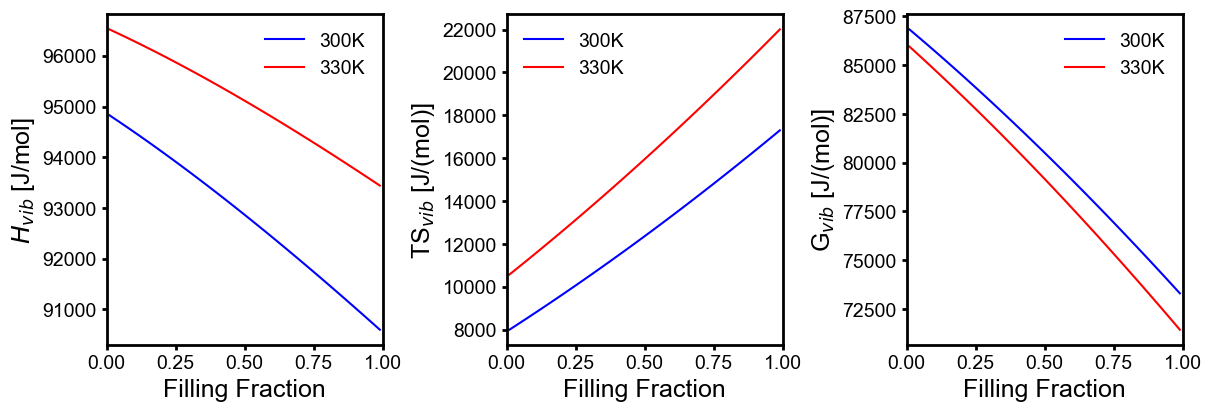

In [17]:
_xs = np.linspace(0.01,0.99, 99)

# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

fig, axes = plt.subplots(1,3, figsize=(12,4),layout='constrained')

# H_vib
ax_now = axes[0]
ax_now.plot(_xs, (_xs+6)*H_vib_LixC6_list_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, (_xs+6)*H_vib_LixC6_list_T2.detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$H_{vib}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# TS_vib
ax_now = axes[1]
ax_now.plot(_xs, (_xs+6)*TS_vib_LixC6_list_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, (_xs+6)*TS_vib_LixC6_list_T2.detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'TS$_{vib}$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# H_vib-TS_vib
ax_now = axes[2]
ax_now.plot(_xs, (_xs+6)*H_vib_LixC6_list_T1.detach().numpy()-(_xs+6)*TS_vib_LixC6_list_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, (_xs+6)*H_vib_LixC6_list_T2.detach().numpy()-(_xs+6)*TS_vib_LixC6_list_T2.detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'G$_{vib}$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


Draw Delta of these things

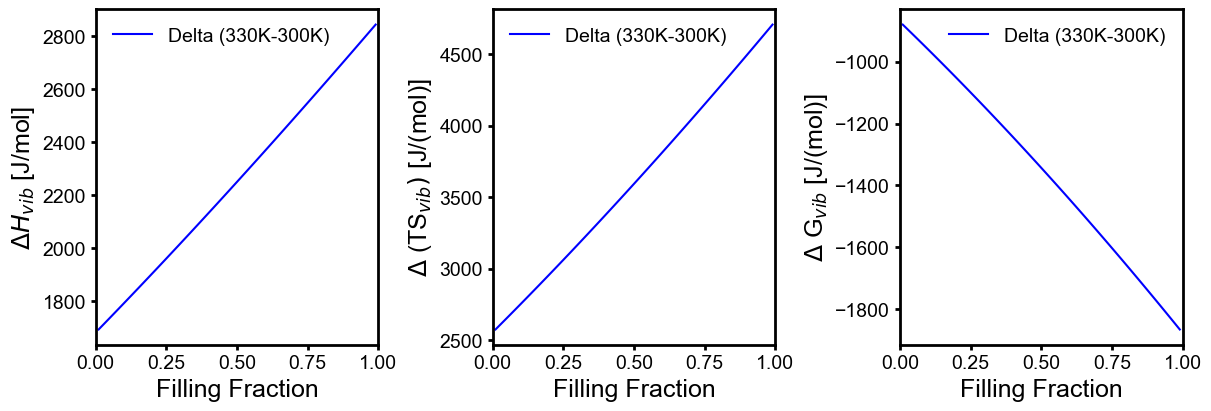

In [18]:
# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

fig, axes = plt.subplots(1,3, figsize=(12,4),layout='constrained')

# H_vib
ax_now = axes[0]
ax_now.plot(_xs, (_xs+6)*H_vib_LixC6_list_T2.detach().numpy()-(_xs+6)*H_vib_LixC6_list_T1.detach().numpy(), "b-", label='Delta (330K-300K)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta H_{vib}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# TS_vib
ax_now = axes[1]
ax_now.plot(_xs, (_xs+6)*TS_vib_LixC6_list_T2.detach().numpy()-(_xs+6)*TS_vib_LixC6_list_T1.detach().numpy(), "b-", label='Delta (330K-300K)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta$ (TS$_{vib})$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# H_vib-TS_vib
ax_now = axes[2]
ax_now.plot(_xs, (_xs+6)*(H_vib_LixC6_list_T2.detach().numpy()-TS_vib_LixC6_list_T2.detach().numpy())-(_xs+6)*(H_vib_LixC6_list_T1.detach().numpy()-TS_vib_LixC6_list_T1.detach().numpy()), "b-", label='Delta (330K-300K)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta$ G$_{vib}$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


Next S_mix and its delta

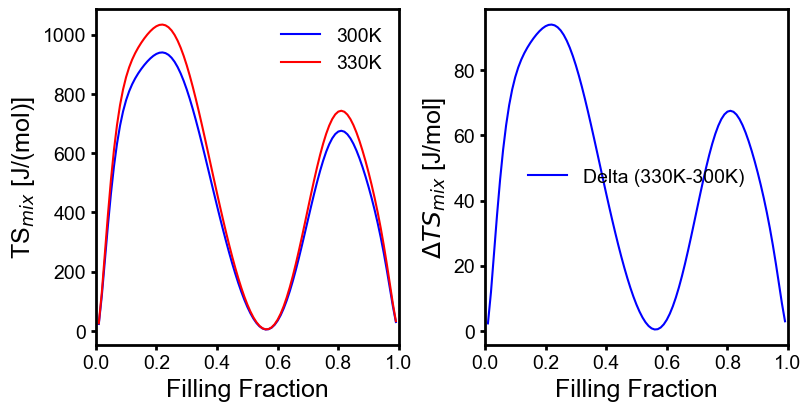

In [19]:
# draw figures 
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

fig, axes = plt.subplots(1,2, figsize=(8,4),layout='constrained')

# G_total
ax_now = axes[0]
ax_now.plot(_xs, s_calculated.detach().numpy()*T1, "b-", label = '300K')
ax_now.plot(_xs, s_calculated.detach().numpy()*T2, "r-", label = '330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'TS$_{mix}$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


# draw delta
ax_now = axes[1]
ax_now.plot(_xs, s_calculated.detach().numpy()*(T2-T1), "b-", label='Delta (330K-300K)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta TS_{mix}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


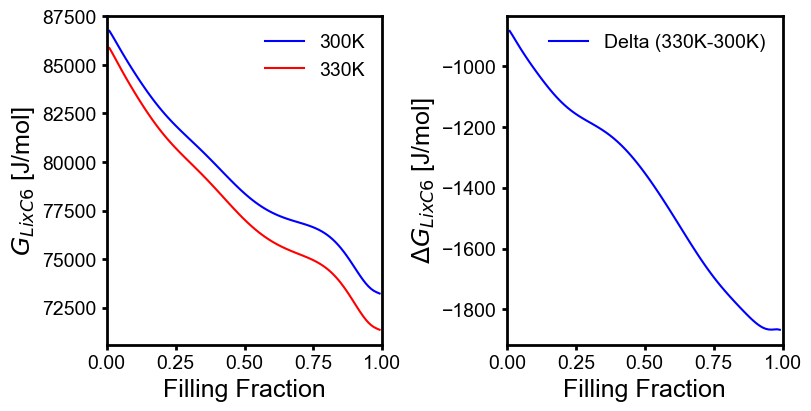

In [20]:
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

fig, axes = plt.subplots(1,2, figsize=(8,4),layout='constrained')

# G_total
ax_now = axes[0]
ax_now.plot(_xs, g_LixC6_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, g_LixC6_T2.detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$G_{LixC6}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


# draw delta
ax_now = axes[1]
ax_now.plot(_xs, g_LixC6_T2.detach().numpy()-g_LixC6_T1.detach().numpy(), "b-", label='Delta (330K-300K)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta G_{LixC6}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


Seems that adding the -TS_mix gives the curved shape of G_LixC6:

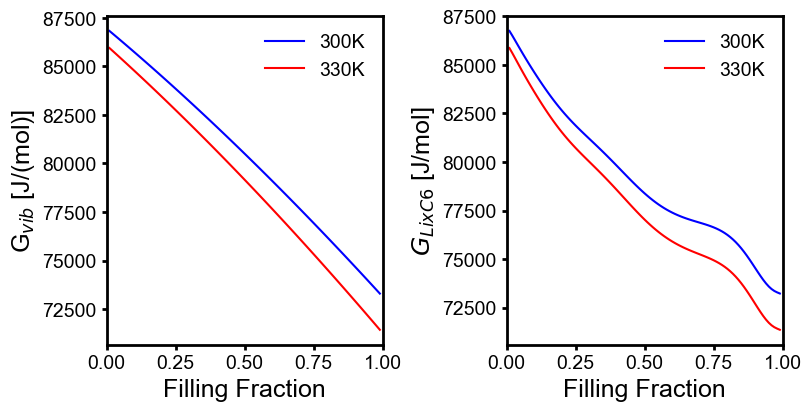

In [21]:
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

fig, axes = plt.subplots(1,2, figsize=(8,4),layout='constrained')

# G_vib
ax_now = axes[0]
ax_now.plot(_xs, g_LixC6_vib_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, g_LixC6_vib_T2.detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'G$_{vib}$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


# G_total
ax_now = axes[1]
ax_now.plot(_xs, g_LixC6_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, g_LixC6_T2.detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$G_{LixC6}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


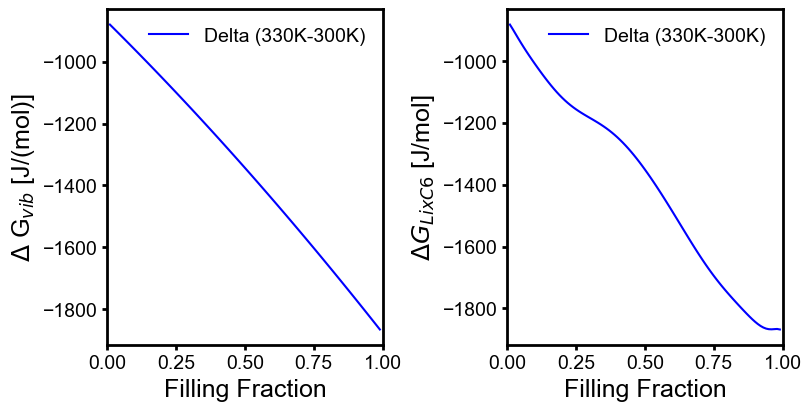

In [22]:
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter

mpl.rc('font',family='Arial')

fig, axes = plt.subplots(1,2, figsize=(8,4),layout='constrained')

# delta of g_vib_Lixc6
ax_now = axes[0]
ax_now.plot(_xs, g_LixC6_vib_T2.detach().numpy()-g_LixC6_vib_T1.detach().numpy(), "b-", label='Delta (330K-300K)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta$ G$_{vib}$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# delta of total g_lixC6
ax_now = axes[1]
ax_now.plot(_xs, g_LixC6_T2.detach().numpy()-g_LixC6_T1.detach().numpy(), "b-", label='Delta (330K-300K)')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\Delta G_{LixC6}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


We also examine mu

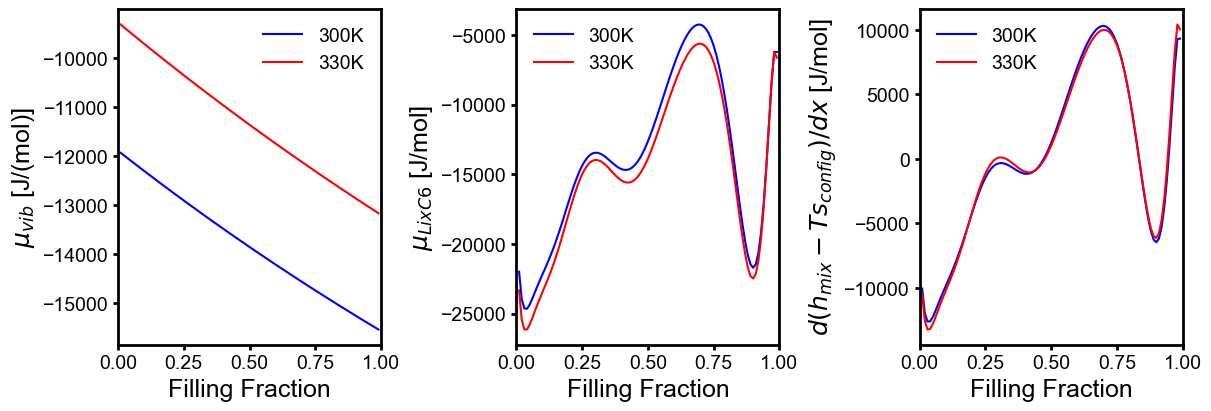

In [23]:
import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

# fig, axes = plt.subplots(1,2, figsize=(8,4),layout='constrained')
fig, axes = plt.subplots(1,3, figsize=(12,4),layout='constrained')


# mu_vib
ax_now = axes[0]
ax_now.plot(_xs, mu_LixC6_vib_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, mu_LixC6_vib_T2.detach().numpy()+3500, "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\mu_{vib}$ [J/(mol)]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# mu_total
ax_now = axes[1]
ax_now.plot(_xs, mu_LixC6_T1.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, mu_LixC6_T2.detach().numpy(), "r-", label='330K')
# ax_now.plot(_xs, -mu_excess_T1.detach().numpy()/96485, "b-", label='300K')
# # ax_now.plot(_xs, -mu_excess_T2.detach().numpy()/96485, "r-", label='400K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$\mu_{LixC6}$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# mu_mix
ax_now = axes[2]
ax_now.plot(_xs, (mu_LixC6_T1-mu_LixC6_vib_T1).detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, (mu_LixC6_T2-mu_LixC6_vib_T2).detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$d(h_{mix}-Ts_{config})/dx$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)



# # convert to OCV
# ax_now = axes[2]
# ax_now.plot(_xs, -mu_LixC6_T1.detach().numpy()/96485, "b-", label='300K')
# # ax_now.plot(_xs, mu_LixC6_T2.detach().numpy(), "r-", label='400K')
# # ax_now.plot(_xs, -mu_excess_T1.detach().numpy()/96485, "b-", label='300K')
# # # ax_now.plot(_xs, -mu_excess_T2.detach().numpy()/96485, "r-", label='400K')
# ax_now.set_xlabel('Filling Fraction', fontsize=18)
# ax_now.set_ylabel(r'$-\mu_{LixC6}/F$ [V]', fontsize=18)
# ax_now.legend(frameon=False, fontsize=14)
# ax_now.set_xlim([0,1])
# ax_now.xaxis.set_tick_params(labelsize=14)
# ax_now.yaxis.set_tick_params(labelsize=14)
# for axis in ['top','bottom','left','right']:
#     ax_now.spines[axis].set_linewidth(2)
# ax_now.tick_params(width=2)


## H_mix

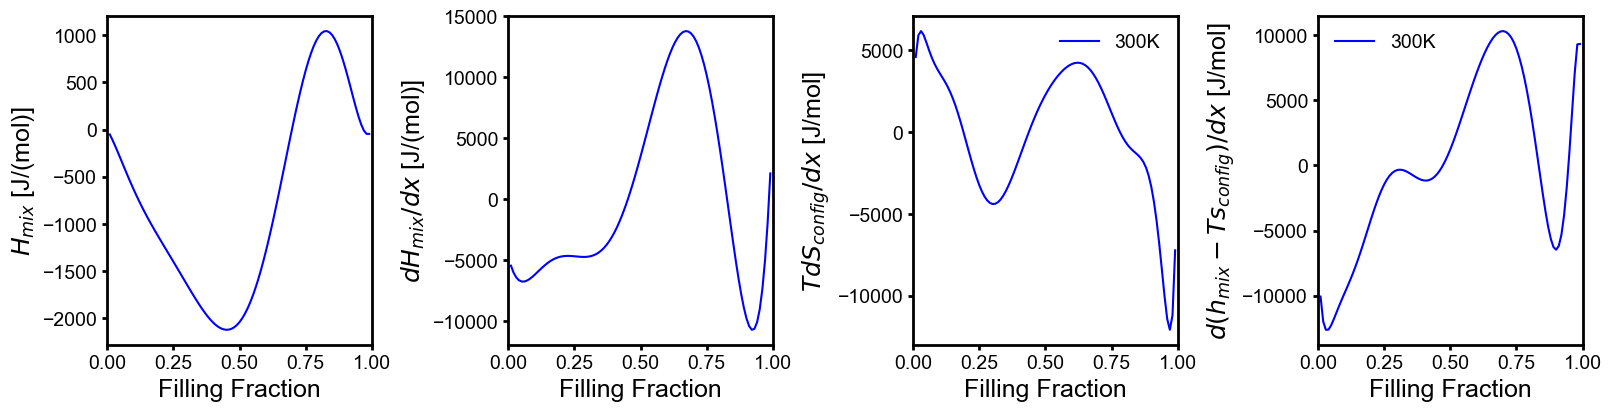

In [24]:

import matplotlib as mpl  
from matplotlib.ticker import FormatStrFormatter
mpl.rc('font',family='Arial')

# fig, axes = plt.subplots(1,2, figsize=(8,4),layout='constrained')
fig, axes = plt.subplots(1,4, figsize=(16,4),layout='constrained')

# x_left = 0.24
# x_right = 0.26
# x_left = 0.46
# x_right = 0.50
x_left = 0
x_right = 1

# H_mix
ax_now = axes[0]
ax_now.plot(_xs, H_mix.detach().numpy(), "b-")
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$H_{mix}$ [J/(mol)]', fontsize=18)
ax_now.set_xlim([x_left, x_right])
# ax_now.set_ylim([-3100, -3000])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# dH_mix/dx
ax_now = axes[1]
ax_now.plot(_xs, dH_mix_dx.detach().numpy(), "b-")
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$dH_{mix}/dx$ [J/(mol)]', fontsize=18)
ax_now.set_xlim([x_left, x_right])
# ax_now.set_ylim([-3100, -3000])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# TdS_config/dx
ax_now = axes[2]
# ax_now.plot(_xs, ds_config_dx.detach().numpy(), "b-", label='300K')
ax_now.plot(_xs, T1*ds_config_dx.detach().numpy(), "b-", label='300K')
# ax_now.plot(_xs, T2*ds_config_dx.detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$TdS_{config}/dx$ [J/mol]', fontsize=18)
# ax_now.set_ylabel(r'$dS_{config}/dx$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([x_left, x_right])
# ax_now.set_ylim([-1800, -700])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)


# mu_mix
ax_now = axes[3]
ax_now.plot(_xs, (dH_mix_dx-T1*ds_config_dx).detach().numpy(), "b-", label='300K')
# ax_now.plot(_xs, (mu_LixC6_T2-mu_LixC6_vib_T2).detach().numpy(), "r-", label='330K')
ax_now.set_xlabel('Filling Fraction', fontsize=18)
ax_now.set_ylabel(r'$d(h_{mix}-Ts_{config})/dx$ [J/mol]', fontsize=18)
ax_now.legend(frameon=False, fontsize=14)
ax_now.set_xlim([0,1])
ax_now.xaxis.set_tick_params(labelsize=14)
ax_now.yaxis.set_tick_params(labelsize=14)
for axis in ['top','bottom','left','right']:
    ax_now.spines[axis].set_linewidth(2)
ax_now.tick_params(width=2)

# 300K boundary: [0.2589, 0.4612], [0.5378, 0.9626]
# 400K boundary: [0.2474, 0.5045], [0.5530, 0.9514]



## Now let's look at mu, dsdx, dh_mix dx and dg_vib/dx

# III and III+II boundary

In [90]:
x_l = torch.tensor([0.2589]).requires_grad_()
x_r = torch.tensor([0.4612]).requires_grad_()
T1 = torch.tensor([300.0]).requires_grad_()
H_mix_x_l_T1 = Hmix_calc(x_l, Omega_G0_list)
H_mix_x_r_T1 = Hmix_calc(x_r, Omega_G0_list)
dH_mix_dx_x_l_T1 = autograd.grad(outputs=H_mix_x_l_T1, inputs=x_l, create_graph=True)[0]
dH_mix_dx_x_r_T1 = autograd.grad(outputs=H_mix_x_r_T1, inputs=x_r, create_graph=True)[0]
S_config_x_l_T1, _, _ = _calculate_S_config_total(x_l, S_config_params_list)
S_config_x_r_T1, _, _ = _calculate_S_config_total(x_r, S_config_params_list)
dS_config_dx_x_l_T1 = autograd.grad(outputs=S_config_x_l_T1, inputs=x_l, create_graph=True)[0]
dS_config_dx_x_r_T1 = autograd.grad(outputs=S_config_x_r_T1, inputs=x_r, create_graph=True)[0]
Theta_max_x_l_T1 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_l, style = style)
Theta_max_x_r_T1 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_r, style = style)
H_vib_x_l_T1 = (x_l+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T1, Theta_max = Theta_max_x_l_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
H_vib_x_r_T1 = (x_r+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T1, Theta_max = Theta_max_x_r_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dH_vib_dx_x_l_T1 = autograd.grad(outputs=H_vib_x_l_T1, inputs=x_l, create_graph=True)[0]
dH_vib_dx_x_r_T1 = autograd.grad(outputs=H_vib_x_r_T1, inputs=x_r, create_graph=True)[0]
TS_vib_x_l_T1 = (x_l+6)*T1*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T1, Theta_max = Theta_max_x_l_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
TS_vib_x_r_T1 = (x_r+6)*T1*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T1, Theta_max = Theta_max_x_r_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dTS_vib_dx_x_l_T1 = autograd.grad(outputs=TS_vib_x_l_T1, inputs=x_l, create_graph=True)[0]
dTS_vib_dx_x_r_T1 = autograd.grad(outputs=TS_vib_x_r_T1, inputs=x_r, create_graph=True)[0]

In [91]:
x_l = torch.tensor([0.2550621927]).requires_grad_() 
x_r = torch.tensor([0.4749700129]).requires_grad_()
T2 = torch.tensor([330.0]).requires_grad_()
H_mix_x_l_T2 = Hmix_calc(x_l, Omega_G0_list)
H_mix_x_r_T2 = Hmix_calc(x_r, Omega_G0_list)
dH_mix_dx_x_l_T2 = autograd.grad(outputs=H_mix_x_l_T2, inputs=x_l, create_graph=True)[0]
dH_mix_dx_x_r_T2 = autograd.grad(outputs=H_mix_x_r_T2, inputs=x_r, create_graph=True)[0]
S_config_x_l_T2, _, _ = _calculate_S_config_total(x_l, S_config_params_list)
S_config_x_r_T2, _, _ = _calculate_S_config_total(x_r, S_config_params_list)
dS_config_dx_x_l_T2 = autograd.grad(outputs=S_config_x_l_T2, inputs=x_l, create_graph=True)[0]
dS_config_dx_x_r_T2 = autograd.grad(outputs=S_config_x_r_T2, inputs=x_r, create_graph=True)[0]
Theta_max_x_l_T2 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_l, style = style)
Theta_max_x_r_T2 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_r, style = style)
H_vib_x_l_T2 = (x_l+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T2, Theta_max = Theta_max_x_l_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
H_vib_x_r_T2 = (x_r+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T2, Theta_max = Theta_max_x_r_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dH_vib_dx_x_l_T2 = autograd.grad(outputs=H_vib_x_l_T2, inputs=x_l, create_graph=True)[0]
dH_vib_dx_x_r_T2 = autograd.grad(outputs=H_vib_x_r_T2, inputs=x_r, create_graph=True)[0]
TS_vib_x_l_T2 = (x_l+6)*T2*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T2, Theta_max = Theta_max_x_l_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
TS_vib_x_r_T2 = (x_r+6)*T2*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T2, Theta_max = Theta_max_x_r_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dTS_vib_dx_x_l_T2 = autograd.grad(outputs=TS_vib_x_l_T2, inputs=x_l, create_graph=True)[0]
dTS_vib_dx_x_r_T2 = autograd.grad(outputs=TS_vib_x_r_T2, inputs=x_r, create_graph=True)[0]

In [94]:
print("At 300K, stage III and III+II boundary, x_left = 0.2589, x_right = 0.4612:")
print("At 330K, stage III and III+II boundary, x_left = 0.2551, x_right = 0.4750:")

# print("Hmix: left (300K %.4f) (330K %.4f), right (300K %.4f) (330K %.4f)" %(H_mix_x_l_T1.detach().numpy(),H_mix_x_l_T2.detach().numpy(), H_mix_x_r_T1.detach().numpy(), H_mix_x_r_T2.detach().numpy()) )
# print("TSmix: left (300K %.4f) (330K %.4f), right (300K %.4f) (330K %.4f)" %((T1*S_config_x_l_T1).detach().numpy(), (T2*S_config_x_l_T2).detach().numpy(), (T1*S_config_x_r_T1).detach().numpy(), (T2*S_config_x_r_T2).detach().numpy()) )
# print("Gvib: lef (300K %.4f) (330K %.4f), right (300K %.4f) (330K %.4f)" %((H_vib_x_l_T1-TS_vib_x_l_T1).detach().numpy(), (H_vib_x_l_T2-TS_vib_x_l_T2).detach().numpy(), (H_vib_x_r_T1-TS_vib_x_r_T1).detach().numpy(), (H_vib_x_r_T2-TS_vib_x_r_T2).detach().numpy()) )
# print("-----")
print("dH_mix/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), it changes because phase boundary (x) changes" %(dH_mix_dx_x_l_T1.detach().numpy(),\
                                                                                                                                dH_mix_dx_x_l_T2.detach().numpy(),\
                                                                                                                                (dH_mix_dx_x_l_T2-dH_mix_dx_x_l_T1).detach().numpy(),\
                                                                                                                                dH_mix_dx_x_r_T1.detach().numpy(),\
                                                                                                                                dH_mix_dx_x_r_T2.detach().numpy(),\
                                                                                                                                (dH_mix_dx_x_r_T2-dH_mix_dx_x_r_T1).detach().numpy()) )
print("TdS_mix/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f)" %((T1*dS_config_dx_x_l_T1).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_l_T2).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_l_T2-T1*dS_config_dx_x_l_T1).detach().numpy(),\
                                                                                (T1*dS_config_dx_x_r_T1).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_r_T2).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_r_T2-T1*dS_config_dx_x_r_T1).detach().numpy()) )
print("dG_vib/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f)" %((dH_vib_dx_x_l_T1-dTS_vib_dx_x_l_T1).detach().numpy(),\
                                                                                (dH_vib_dx_x_l_T2-dTS_vib_dx_x_l_T2).detach().numpy(),\
                                                                                ((dH_vib_dx_x_l_T2-dTS_vib_dx_x_l_T2)-(dH_vib_dx_x_l_T1-dTS_vib_dx_x_l_T1)).detach().numpy(),\
                                                                                (dH_vib_dx_x_r_T1-dTS_vib_dx_x_r_T1).detach().numpy(),\
                                                                                (dH_vib_dx_x_r_T2-dTS_vib_dx_x_r_T2).detach().numpy(),\
                                                                                ((dH_vib_dx_x_r_T2-dTS_vib_dx_x_r_T2)-(dH_vib_dx_x_r_T1-dTS_vib_dx_x_r_T1)).detach().numpy()) )
print("dH_vib/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f)" %((dH_vib_dx_x_l_T1).detach().numpy(),\
                                                                                (dH_vib_dx_x_l_T2).detach().numpy(),\
                                                                                ((dH_vib_dx_x_l_T2)-(dH_vib_dx_x_l_T1)).detach().numpy(),\
                                                                                (dH_vib_dx_x_r_T1).detach().numpy(),\
                                                                                (dH_vib_dx_x_r_T2).detach().numpy(),\
                                                                                ((dH_vib_dx_x_r_T2)-(dH_vib_dx_x_r_T1)).detach().numpy()) )
print("dTS_vib/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f)" %((dTS_vib_dx_x_l_T1).detach().numpy(),\
                                                                                (dTS_vib_dx_x_l_T2).detach().numpy(),\
                                                                                ((dTS_vib_dx_x_l_T2)-(dTS_vib_dx_x_l_T1)).detach().numpy(),\
                                                                                (dTS_vib_dx_x_r_T1).detach().numpy(),\
                                                                                (dTS_vib_dx_x_r_T2).detach().numpy(),\
                                                                                ((dTS_vib_dx_x_r_T2)-(dTS_vib_dx_x_r_T1)).detach().numpy()) )


# print("-----")
# mu_tot_left_T1 = (dH_mix_dx_x_l_T1 - T1*dS_config_dx_x_l_T1 + dH_vib_dx_x_l_T1-dTS_vib_dx_x_l_T1).detach().numpy()
# mu_tot_right_T1 = (dH_mix_dx_x_r_T1 - T1*dS_config_dx_x_r_T1 + dH_vib_dx_x_r_T1-dTS_vib_dx_x_r_T1).detach().numpy()
# print("Sum of derivative at 300K (with vib): left %.4f, right %.4f" %(mu_tot_left_T1, mu_tot_right_T1))
# mu_tot_left_T2 = (dH_mix_dx_x_l_T2 - T2*dS_config_dx_x_l_T2 + dH_vib_dx_x_l_T2-dTS_vib_dx_x_l_T2).detach().numpy()
# mu_tot_right_T2 = (dH_mix_dx_x_r_T2 - T2*dS_config_dx_x_r_T2 + dH_vib_dx_x_r_T2-dTS_vib_dx_x_r_T2).detach().numpy()
# print("Sum of derivative at 330K (with vib): left %.4f, right %.4f" %(mu_tot_left_T2, mu_tot_right_T2))


At 300K, stage III and III+II boundary, x_left = 0.2589, x_right = 0.4612:
At 330K, stage III and III+II boundary, x_left = 0.2551, x_right = 0.4750:
dH_mix/dx: left (300K -4716.6592) (330K -4708.5215) (Delta(330K-300K) 8.1377), right (300K 613.0958) (330K 1592.0933) (Delta(330K-300K) 978.9974), it changes because phase boundary (x) changes
TdS_mix/dx: left (300K -3581.0769) (330K -3781.7607) (Delta(330K-300K) -200.6838), right (300K 976.2623) (330K 1627.9990) (Delta(330K-300K) 651.7368)
dG_vib/dx: left (300K -12936.9053) (330K -13867.0352) (Delta(330K-300K) -930.1299), right (300K -13707.0000) (330K -14757.8857) (Delta(330K-300K) -1050.8857)
dH_vib/dx: left (300K -4024.7500) (330K -2881.8906) (Delta(330K-300K) 1142.8594), right (300K -4305.8750) (330K -3152.6094) (Delta(330K-300K) 1153.2656)
dTS_vib/dx: left (300K 8912.1553) (330K 10985.1445) (Delta(330K-300K) 2072.9893), right (300K 9401.1250) (330K 11605.2764) (Delta(330K-300K) 2204.1514)


# II and II+I boundary

In [102]:
x_l = torch.tensor([0.5378]).requires_grad_()
x_r = torch.tensor([0.9626]).requires_grad_()
T1 = torch.tensor([300.0]).requires_grad_()
H_mix_x_l_T1 = Hmix_calc(x_l, Omega_G0_list)
H_mix_x_r_T1 = Hmix_calc(x_r, Omega_G0_list)
dH_mix_dx_x_l_T1 = autograd.grad(outputs=H_mix_x_l_T1, inputs=x_l, create_graph=True)[0]
dH_mix_dx_x_r_T1 = autograd.grad(outputs=H_mix_x_r_T1, inputs=x_r, create_graph=True)[0]
S_config_x_l_T1, _, _ = _calculate_S_config_total(x_l, S_config_params_list)
S_config_x_r_T1, _, _ = _calculate_S_config_total(x_r, S_config_params_list)
dS_config_dx_x_l_T1 = autograd.grad(outputs=S_config_x_l_T1, inputs=x_l, create_graph=True)[0]
dS_config_dx_x_r_T1 = autograd.grad(outputs=S_config_x_r_T1, inputs=x_r, create_graph=True)[0]
Theta_max_x_l_T1 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_l, style = style)
Theta_max_x_r_T1 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_r, style = style)
H_vib_x_l_T1 = (x_l+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T1, Theta_max = Theta_max_x_l_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
H_vib_x_r_T1 = (x_r+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T1, Theta_max = Theta_max_x_r_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dH_vib_dx_x_l_T1 = autograd.grad(outputs=H_vib_x_l_T1, inputs=x_l, create_graph=True)[0]
dH_vib_dx_x_r_T1 = autograd.grad(outputs=H_vib_x_r_T1, inputs=x_r, create_graph=True)[0]
TS_vib_x_l_T1 = (x_l+6)*T1*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T1, Theta_max = Theta_max_x_l_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
TS_vib_x_r_T1 = (x_r+6)*T1*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T1, Theta_max = Theta_max_x_r_T1, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dTS_vib_dx_x_l_T1 = autograd.grad(outputs=TS_vib_x_l_T1, inputs=x_l, create_graph=True)[0]
dTS_vib_dx_x_r_T1 = autograd.grad(outputs=TS_vib_x_r_T1, inputs=x_r, create_graph=True)[0]

In [103]:
x_l = torch.tensor([0.5421]).requires_grad_() 
x_r = torch.tensor([0.9589]).requires_grad_()
T2 = torch.tensor([330.0]).requires_grad_()
H_mix_x_l_T2 = Hmix_calc(x_l, Omega_G0_list)
H_mix_x_r_T2 = Hmix_calc(x_r, Omega_G0_list)
dH_mix_dx_x_l_T2 = autograd.grad(outputs=H_mix_x_l_T2, inputs=x_l, create_graph=True)[0]
dH_mix_dx_x_r_T2 = autograd.grad(outputs=H_mix_x_r_T2, inputs=x_r, create_graph=True)[0]
S_config_x_l_T2, _, _ = _calculate_S_config_total(x_l, S_config_params_list)
S_config_x_r_T2, _, _ = _calculate_S_config_total(x_r, S_config_params_list)
dS_config_dx_x_l_T2 = autograd.grad(outputs=S_config_x_l_T2, inputs=x_l, create_graph=True)[0]
dS_config_dx_x_r_T2 = autograd.grad(outputs=S_config_x_r_T2, inputs=x_r, create_graph=True)[0]
Theta_max_x_l_T2 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_l, style = style)
Theta_max_x_r_T2 = solve_Theta_max(g_ij_matrix = g_ij_list_LixHM, is_x_dependent = True, x = x_r, style = style)
H_vib_x_l_T2 = (x_l+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T2, Theta_max = Theta_max_x_l_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
H_vib_x_r_T2 = (x_r+6)*_H_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T2, Theta_max = Theta_max_x_r_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dH_vib_dx_x_l_T2 = autograd.grad(outputs=H_vib_x_l_T2, inputs=x_l, create_graph=True)[0]
dH_vib_dx_x_r_T2 = autograd.grad(outputs=H_vib_x_r_T2, inputs=x_r, create_graph=True)[0]
TS_vib_x_l_T2 = (x_l+6)*T2*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_l, T = T2, Theta_max = Theta_max_x_l_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
TS_vib_x_r_T2 = (x_r+6)*T2*_S_vib_PDOS_quaderature_model(g_ij_matrix = g_ij_list_LixHM, x = x_r, T = T2, Theta_max = Theta_max_x_r_T2, is_x_dependent = True, quaderature_points=quaderature_points, style = "Legendre")
dTS_vib_dx_x_l_T2 = autograd.grad(outputs=TS_vib_x_l_T2, inputs=x_l, create_graph=True)[0]
dTS_vib_dx_x_r_T2 = autograd.grad(outputs=TS_vib_x_r_T2, inputs=x_r, create_graph=True)[0]

In [105]:
print("At 300K, stage II and II+I boundary, x_left = 0.5378, x_right = 0.9626:")
print("At 330K, stage II and II+I boundary, x_left = 0.5421, x_right = 0.9589:")

# print("Hmix: left (300K %.4f) (330K %.4f), right (300K %.4f) (330K %.4f)" %(H_mix_x_l_T1.detach().numpy(),H_mix_x_l_T2.detach().numpy(), H_mix_x_r_T1.detach().numpy(), H_mix_x_r_T2.detach().numpy()) )
# print("TSmix: left (300K %.4f) (330K %.4f), right (300K %.4f) (330K %.4f)" %((T1*S_config_x_l_T1).detach().numpy(), (T2*S_config_x_l_T2).detach().numpy(), (T1*S_config_x_r_T1).detach().numpy(), (T2*S_config_x_r_T2).detach().numpy()) )
# print("Gvib: lef (300K %.4f) (330K %.4f), right (300K %.4f) (330K %.4f)" %((H_vib_x_l_T1-TS_vib_x_l_T1).detach().numpy(), (H_vib_x_l_T2-TS_vib_x_l_T2).detach().numpy(), (H_vib_x_r_T1-TS_vib_x_r_T1).detach().numpy(), (H_vib_x_r_T2-TS_vib_x_r_T2).detach().numpy()) )
# print("-----")
print("dH_mix/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), it changes because phase boundary (x) changes" %(dH_mix_dx_x_l_T1.detach().numpy(),\
                                                                                                                                dH_mix_dx_x_l_T2.detach().numpy(),\
                                                                                                                                (dH_mix_dx_x_l_T2-dH_mix_dx_x_l_T1).detach().numpy(),\
                                                                                                                                dH_mix_dx_x_r_T1.detach().numpy(),\
                                                                                                                                dH_mix_dx_x_r_T2.detach().numpy(),\
                                                                                                                                (dH_mix_dx_x_r_T2-dH_mix_dx_x_r_T1).detach().numpy()) )
print("TdS_mix/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f)" %((T1*dS_config_dx_x_l_T1).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_l_T2).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_l_T2-T1*dS_config_dx_x_l_T1).detach().numpy(),\
                                                                                (T1*dS_config_dx_x_r_T1).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_r_T2).detach().numpy(),\
                                                                                (T2*dS_config_dx_x_r_T2-T1*dS_config_dx_x_r_T1).detach().numpy()) )
print("dG_vib/dx: left (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f), right (300K %.4f) (330K %.4f) (Delta(330K-300K) %.4f)" %((dH_vib_dx_x_l_T1-dTS_vib_dx_x_l_T1).detach().numpy(),\
                                                                                (dH_vib_dx_x_l_T2-dTS_vib_dx_x_l_T2).detach().numpy(),\
                                                                                ((dH_vib_dx_x_l_T2-dTS_vib_dx_x_l_T2)-(dH_vib_dx_x_l_T1-dTS_vib_dx_x_l_T1)).detach().numpy(),\
                                                                                (dH_vib_dx_x_r_T1-dTS_vib_dx_x_r_T1).detach().numpy(),\
                                                                                (dH_vib_dx_x_r_T2-dTS_vib_dx_x_r_T2).detach().numpy(),\
                                                                                ((dH_vib_dx_x_r_T2-dTS_vib_dx_x_r_T2)-(dH_vib_dx_x_r_T1-dTS_vib_dx_x_r_T1)).detach().numpy()) )
# print("-----")
# mu_tot_left_T1 = (dH_mix_dx_x_l_T1 - T1*dS_config_dx_x_l_T1 + dH_vib_dx_x_l_T1-dTS_vib_dx_x_l_T1).detach().numpy()
# mu_tot_right_T1 = (dH_mix_dx_x_r_T1 - T1*dS_config_dx_x_r_T1 + dH_vib_dx_x_r_T1-dTS_vib_dx_x_r_T1).detach().numpy()
# print("Sum of derivative at 300K (with vib): left %.4f, right %.4f" %(mu_tot_left_T1, mu_tot_right_T1))
# mu_tot_left_T2 = (dH_mix_dx_x_l_T2 - T2*dS_config_dx_x_l_T2 + dH_vib_dx_x_l_T2-dTS_vib_dx_x_l_T2).detach().numpy()
# mu_tot_right_T2 = (dH_mix_dx_x_r_T2 - T2*dS_config_dx_x_r_T2 + dH_vib_dx_x_r_T2-dTS_vib_dx_x_r_T2).detach().numpy()
# print("Sum of derivative at 330K (with vib): left %.4f, right %.4f" %(mu_tot_left_T2, mu_tot_right_T2))


At 300K, stage II and II+I boundary, x_left = 0.5378, x_right = 0.9626:
At 330K, stage II and II+I boundary, x_left = 0.5421, x_right = 0.9589:
dH_mix/dx: left (300K 6615.4570) (330K 6969.1074) (Delta(330K-300K) 353.6504), right (300K -6843.1406) (330K -7600.3896) (Delta(330K-300K) -757.2490), it changes because phase boundary (x) changes
TdS_mix/dx: left (300K 3251.6934) (330K 3676.7180) (Delta(330K-300K) 425.0247), right (300K -11678.1533) (330K -12411.3154) (Delta(330K-300K) -733.1621)
dG_vib/dx: left (300K -13987.7676) (330K -15020.0059) (Delta(330K-300K) -1032.2383), right (300K -15445.0273) (330K -16552.2773) (Delta(330K-300K) -1107.2500)
